# Отчет по практической работе решение задач кластерного анализа

### Подготовил: Пацев В. В.
### Студент группы: Иэс-160п-18

Задание будем делать помощью языка Python инструмента [Jupyter Notebook](https://jupyter.org/)
и общедоступных библиотек с открытым кодом:
- [Pandas](https://pandas.pydata.org/)
- [Numpy](https://numpy.org/)
- [Matplotlib](https://matplotlib.org/)
- [Scipy](https://www.scipy.org/)

Добавим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

plt.close("all")

Подготовим данные из исходных данных задания из **варианта №6** и подготовим dataframe

In [2]:
data = [
    [8.22,0.25], 
    [4.33, 0.49], 
    [6.45,0.51], 
    [6.39,0.27], 
    [4.92,0.32], 
    [6.5,0.43]]
df = pd.DataFrame.from_records(data, columns=('X1', 'X2'), index=[1,2,3,4,5,6])
df

# Матрица объектов

,X1,X2
1,8.22,0.25
2,4.33,0.49
3,6.45,0.51
4,6.39,0.27
5,4.92,0.32
6,6.50,0.43


Визуализируем распределиние объектов по пространству признаков X1, X2

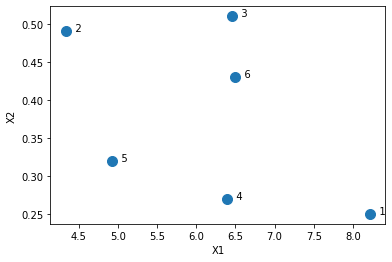

In [3]:
ax = df.plot.scatter(x="X1", y="X2", s=100);
for i, point in df.iterrows():
    ax.text(point['X1'], point['X2'], "   " + str(i))

Найдем попарные Евклидово расстояния между объектами по формуле

$
p(X_iX_j) = \sqrt{(X1_i-X1_j)^2 + (X2_i-X2_j)^2}
$

In [4]:
def get_dst(col):
    dst = np.sqrt(
        abs(df.iloc[col.name-1]['X1'] - df.iloc[col.index-1]['X1']) ** 2 +
        abs(df.iloc[col.name-1]['X2'] - df.iloc[col.index-1]['X2']) ** 2
    )
    return dst

df_distance = pd.DataFrame(index=df.index, columns=df.index).apply(get_dst)
df_distance

,1,2,3,4,5,6
1,0.000000,3.897397,1.788994,1.830109,3.300742,1.729393
2,3.897397,0.000000,2.120094,2.071714,0.614003,2.170829
3,1.788994,2.120094,0.000000,0.247386,1.541752,0.094340
4,1.830109,2.071714,0.247386,0.000000,1.470850,0.194165
5,3.300742,0.614003,1.541752,1.470850,0.000000,1.583824
6,1.729393,2.170829,0.094340,0.194165,1.583824,0.000000


### Принцип «ближайшего соседа»

Определим функцию **get_nn** которая определяет ближайшего соседа или дальнего соседа (параметр **is_nearest**)

In [5]:
def get_nn(df_d, is_nearest, cluster_1, cluster_2, ):
    index = {}
    df_d_copy = df_d.copy()
   
    if type(cluster_1) is tuple and type(cluster_2) is tuple:
        new_cluster = (*cluster_1, *cluster_2)
    elif type(cluster_1) is tuple:
        new_cluster = (*cluster_1, cluster_2)
    elif type(cluster_2) is tuple:
        new_cluster = (cluster_1, *cluster_2)
    else:
        new_cluster = (cluster_1, cluster_2)
    
    index[cluster_2] = new_cluster
    
    
    def fn(x):
        if x in new_cluster:
            return 0
        elif type(x) is tuple and set(x).issubset(set(new_cluster)):
            return 0
        elif type(x) is tuple:
            l = [df_distance.at[k_x, k] for k_x in x for k in new_cluster]
        else:
            l = [df_distance.at[x, k] for k in new_cluster]
        return min(l) if is_nearest else max(l)
    
    new_data = [fn(i) for i in df_d_copy[cluster_2].index]
    
    df_d_copy[cluster_2] = new_data
    df_d_copy.iloc[list(df_d_copy.index).index(cluster_2)] = new_data
    
    return df_d_copy.drop(index=cluster_1, columns=cluster_1, inplace=False).rename(index=index, columns=index)
        

Найдем минимальное расстояние между парами

In [6]:
min1 = df_distance[df_distance > 0].min().min()
min1

0.09433981132056596

Найдем объекты между которыми это минимальное расстояние

In [7]:
filtered1 = (
    df_distance[df_distance == min1]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered1

,3,6
3,NaN,0.09434
6,0.09434,NaN


Добавим объекты **3** и **6** в кластер

In [8]:
df_distance1 = get_nn(df_distance, True, *filtered1.index)
df_distance1

,1,2,4,5,"(3, 6)"
1,0.000000,3.897397,1.830109,3.300742,1.729393
2,3.897397,0.000000,2.071714,0.614003,2.120094
4,1.830109,2.071714,0.000000,1.470850,0.194165
5,3.300742,0.614003,1.470850,0.000000,1.541752
"(3, 6)",1.729393,2.120094,0.194165,1.541752,0.000000


Снова найдем минимальное расстояние между объектами

In [9]:
min2 = df_distance1[df_distance1 > 0].min().min()
min2

0.19416487838947613

Найдем объекты между которыми это минимальное расстояние

In [10]:
filtered2 = (
    df_distance1[df_distance1 == min2]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered2

,4,"(3, 6)"
4,NaN,0.194165
"(3, 6)",0.194165,NaN


Добавим объект **4** в кластер **(3,6)**

In [11]:
df_distance2 = get_nn(df_distance1, True, *filtered2.index)
df_distance2

,1,2,5,"(4, 3, 6)"
1,0.000000,3.897397,3.300742,1.729393
2,3.897397,0.000000,0.614003,2.071714
5,3.300742,0.614003,0.000000,1.470850
"(4, 3, 6)",1.729393,2.071714,1.470850,0.000000


Снова найдем минимальное расстояние между объектами

In [12]:
min3 = df_distance2[df_distance2 > 0].min().min()
min3

0.6140032573203499

Найдем объекты между которыми это минимальное расстояние

In [13]:
filtered3 = (
    df_distance2[df_distance2 == min3]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered3

,2,5
2,NaN,0.614003
5,0.614003,NaN


Добавим объекты **2** и **5** в кластер

In [14]:
df_distance3 = get_nn(df_distance2, True, *filtered3.index)
df_distance3

,1,"(2, 5)","(4, 3, 6)"
1,0.000000,3.300742,1.729393
"(2, 5)",3.300742,0.000000,1.470850
"(4, 3, 6)",1.729393,1.470850,0.000000


Снова найдем минимальное расстояние между объектами

In [15]:
min4 = df_distance3[df_distance3 > 0].min().min()
min4

1.4708500943332055

Найдем объекты между которыми это минимальное расстояние

In [16]:
filtered4 = (
    df_distance3[df_distance3 == min4]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered4

,"(2, 5)","(4, 3, 6)"
"(2, 5)",NaN,1.47085
"(4, 3, 6)",1.47085,NaN


Объединим кластеры **(2, 5)** и **(4, 3, 6)**

In [17]:
df_distance4 = get_nn(df_distance3, True, *filtered4.index)
df_distance4

,1,"(2, 5, 4, 3, 6)"
1,0.000000,1.729393
"(2, 5, 4, 3, 6)",1.729393,0.000000


Получилось 2 кластера
- 1
- (2, 5, 4, 3, 6)

Визуализируем получившиеся кластера

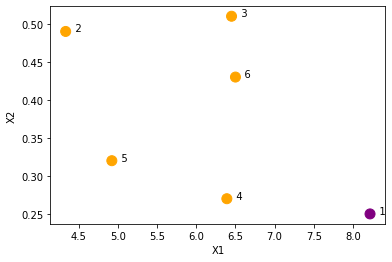

In [18]:
colors = ['purple', 'orange']


def get_color(index):
    for i, s in enumerate(df_distance4.index):
        if type(s) is tuple:
            if index in s:
                return colors[i]
        else:
             if index == s:
                return colors[i]
    return 'blue'    
ax = df.plot.scatter(x="X1", y="X2", s=100, c=[get_color(i) for i in range(1,7)]);

for i, point in df.iterrows():
    ax.text(point['X1'], point['X2'], "   " + str(i))

Построим дендрограмму, так же проверим свое решение, получив результат с помощью библиотеки [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)

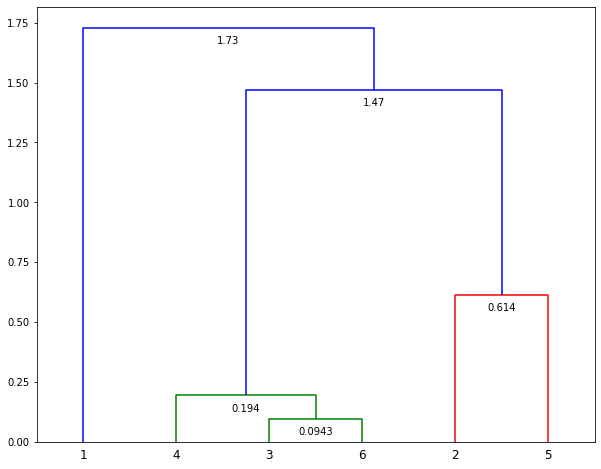

In [19]:
Z = linkage(data, 'single')
fig = plt.figure(figsize=(10, 8))
dn = dendrogram(Z, labels=[1,2,3,4,5,6])

for i, d in zip(dn['icoord'], dn['dcoord']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                 textcoords='offset points',
                 va='top', ha='center')
    
plt.show()

**Вывод:** Как мы видим результаты полученные ручным способом совпадают с результатом работы библиотеки 

### Принцип «дальнего соседа»

Для этого воспользуемся функцией **get_nn** с параметром **is_nearest=False**

Найдем минимальное расстояние между парами

In [20]:
min5 = df_distance[df_distance > 0].min().min()
min5

0.09433981132056596

Найдем объекты между которыми это минимальное расстояние

In [21]:
filtered4 = (
    df_distance[df_distance == min5]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered4

,3,6
3,NaN,0.09434
6,0.09434,NaN


Добавим объекты **3** и **6** в кластер

In [22]:
df_distance5 = get_nn(df_distance, False, *filtered4.index)
df_distance5

,1,2,4,5,"(3, 6)"
1,0.000000,3.897397,1.830109,3.300742,1.788994
2,3.897397,0.000000,2.071714,0.614003,2.170829
4,1.830109,2.071714,0.000000,1.470850,0.247386
5,3.300742,0.614003,1.470850,0.000000,1.583824
"(3, 6)",1.788994,2.170829,0.247386,1.583824,0.000000


Снова найдем минимальное расстояние между объектами

In [23]:
min6 = df_distance5[df_distance5 > 0].min().min()
min6

0.24738633753705974

Найдем объекты между которыми это минимальное расстояние

In [24]:
filtered5 = (
    df_distance5[df_distance5 == min6]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered5

,4,"(3, 6)"
4,NaN,0.247386
"(3, 6)",0.247386,NaN


Добавим объект **4** в кластер **(3, 6)**

In [25]:
df_distance6 = get_nn(df_distance5, False, *filtered5.index)
df_distance6

,1,2,5,"(4, 3, 6)"
1,0.000000,3.897397,3.300742,1.830109
2,3.897397,0.000000,0.614003,2.170829
5,3.300742,0.614003,0.000000,1.583824
"(4, 3, 6)",1.830109,2.170829,1.583824,0.000000


Снова найдем минимальное расстояние между объектами

In [26]:
min7 = df_distance6[df_distance6 > 0].min().min()
min7

0.6140032573203499

Найдем объекты между которыми это минимальное расстояние

In [27]:
filtered6 = (
    df_distance6[df_distance6 == min7]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered6

,2,5
2,NaN,0.614003
5,0.614003,NaN


Добавим объект **5** и **2** в кластер

In [28]:
df_distance7 = get_nn(df_distance6, False, *filtered6.index)
df_distance7

,1,"(2, 5)","(4, 3, 6)"
1,0.000000,3.897397,1.830109
"(2, 5)",3.897397,0.000000,2.170829
"(4, 3, 6)",1.830109,2.170829,0.000000


Снова найдем минимальное расстояние между объектами

In [29]:
min8 = df_distance7[df_distance7 > 0].min().min()
min8

1.8301092863542339

Найдем объекты между которыми это минимальное расстояние

In [30]:
filtered7 = (
    df_distance6[df_distance6 == min8]
    .dropna(how='all')
    .dropna(how='all', axis=1)
)
filtered7

,1,"(4, 3, 6)"
1,NaN,1.830109
"(4, 3, 6)",1.830109,NaN


Добавим объект **1** в кластер **(4, 3, 6)**

In [31]:
df_distance8 = get_nn(df_distance7, False, *filtered7.index)
df_distance8

,"(2, 5)","(1, 4, 3, 6)"
"(2, 5)",0.000000,3.897397
"(1, 4, 3, 6)",3.897397,0.000000


Получилось 2 кластера
- (2, 5)
- (1, 4, 3, 6)

In [32]:
Визуализируем получившиеся кластера

SyntaxError: invalid syntax (<ipython-input-32-e6874f1702f8>, line 1)

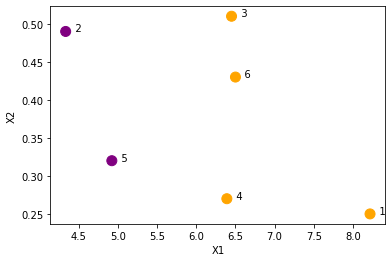

In [33]:
colors = ['purple', 'orange']


def get_color(index):
    for i, s in enumerate(df_distance8.index):
        if type(s) is tuple:
            if index in s:
                return colors[i]
        else:
             if index == s:
                return colors[i]
    return 'blue'    
ax = df.plot.scatter(x="X1", y="X2", s=100, c=[get_color(i) for i in range(1,7)]);

for i, point in df.iterrows():
    ax.text(point['X1'], point['X2'], "   " + str(i))

Построим дендрограмму, так же проверим свое решение, получив результат с помощью библиотеки [scipy.cluster.hierarchy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html#scipy.cluster.hierarchy.linkage)

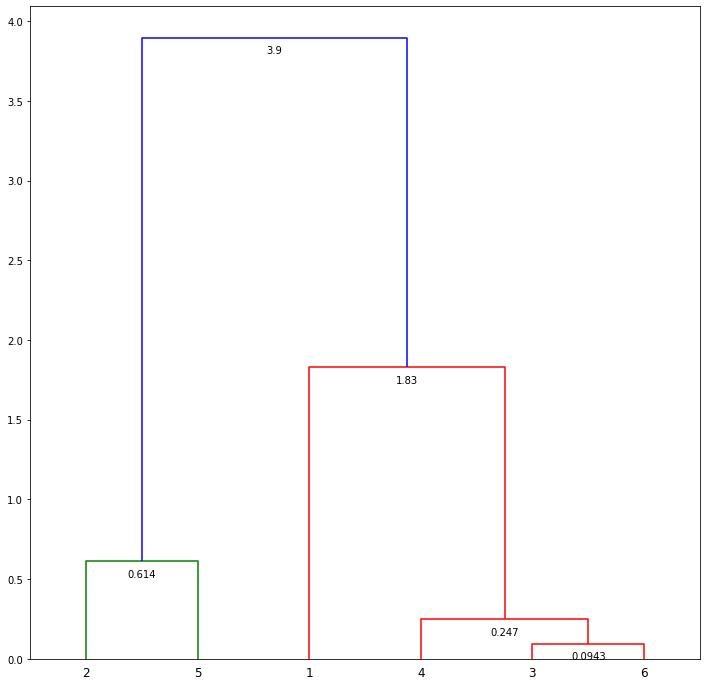

In [34]:
Z = linkage(data, 'complete')
fig = plt.figure(figsize=(12, 12))
dn = dendrogram(Z, labels=[1,2,3,4,5,6])

for i, d in zip(dn['icoord'], dn['dcoord']):
    x = 0.5 * sum(i[1:3])
    y = d[1]
    plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                 textcoords='offset points',
                 va='top', ha='center')
    
plt.show()

**Вывод:** Как мы видим результаты полученные ручным способом совпадают с результатом работы библиотеки 